In [56]:
import torch
import torch.nn as nn

### Common

In [57]:
def get_conv2d(c1, c2, k, p, s, d, g, bias=False):
    conv = nn.Conv2d(c1, c2, k, stride=s, padding=p, dilation=d, groups=g, bias=bias)
    return conv

def get_activation(act=None):
    if act == 'relu':
        return nn.ReLU(inplace=True)
    elif act == 'lrelu':
        return nn.LeakyReLU(inplace=True)
    elif act == 'mish':
        return nn.Mish(inplace=True)
    elif act == 'silu':
        return nn.SiLU(inplace=True)
    
def get_norm(norm, dim):
    if norm == 'bn':
        return nn.BatchNorm2d(num_features=dim)
    elif norm == 'gn':
        return nn.GroupNorm(num_groups=32, num_channels=dim)

In [58]:
class Conv(nn.Module):
    def __init__(self, c1, c2, k=1, p=0, s=1, d=1, act='lrelu', norm='bn', depthwise=False):
        super().__init__()
        convs = []
        bias = False if norm else True
        #
        if depthwise:

            # depth-wise

            convs.append(get_conv2d(c1, c1, k, p, s, d, g=c1, bias=bias))

            if norm:
                convs.append(get_norm(norm, c1))
            if act:
                convs.append(get_activation(act))

            # point-wise

            convs.append(get_conv2d(c1, c2, k=1, p=0, s=1, d=d, g=1, bias=bias))

            if norm:
                convs.append(get_norm(norm, c2))
            if act:
                convs.append(get_activation(act))

        else:
            convs.append(get_conv2d(c1, c2, k=k, p=p, s=s, d=d, g=1, bias=bias))

            if norm:
                convs.append(get_norm(norm, c2))
            if act:
                convs.append(get_activation(act))

        self.convs = nn.Sequential(*convs)

    def forward(self, x):
        return self.convs(x)



### YOLOv2 

![image](https://media.geeksforgeeks.org/wp-content/uploads/20200327225305/darknet-19-YOLOv2.png)

In [59]:
#-----------------Conv------------------# <BN, LReLU>

class Conv_BN_LeakyReLU(nn.Module):
    def __init__(self, c1, c2, k, p=0, s=1, d=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(c1, c2, k, s, p, d),
            nn.BatchNorm2d(c2),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
    def forward(self, x):
        return self.convs(x)

In [60]:
#-----------------DarkNet-19------------------# <Backbone>

class DarkNet19(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv_BN_LeakyReLU(3, 32, k=3, p=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #
            Conv_BN_LeakyReLU(32, 64, k=3, p=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #
            Conv_BN_LeakyReLU(64, 128, k=3, p=1),
            Conv_BN_LeakyReLU(128, 64, k=1, p=1),
            Conv_BN_LeakyReLU(64, 128, k=3, p=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #
            Conv_BN_LeakyReLU(128, 256, k=3, p=1),
            Conv_BN_LeakyReLU(256, 128, k=1, p=1),
            Conv_BN_LeakyReLU(128, 256, k=3, p=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #
            Conv_BN_LeakyReLU(256, 512, k=3, p=1),
            Conv_BN_LeakyReLU(512, 256, k=1, p=1),
            Conv_BN_LeakyReLU(256, 512, k=3, p=1),
            Conv_BN_LeakyReLU(512, 256, k=1, p=1),
            Conv_BN_LeakyReLU(256, 512, k=3, p=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #
            Conv_BN_LeakyReLU(512, 1024, k=3, p=1),
            Conv_BN_LeakyReLU(1024, 512, k=1, p=1),
            Conv_BN_LeakyReLU(512, 1024, k=3, p=1),
            Conv_BN_LeakyReLU(1024, 512, k=1, p=1),
            Conv_BN_LeakyReLU(512, 1024, k=3, p=1),
        )

    def forward(self, x):
        return self.layers(x)

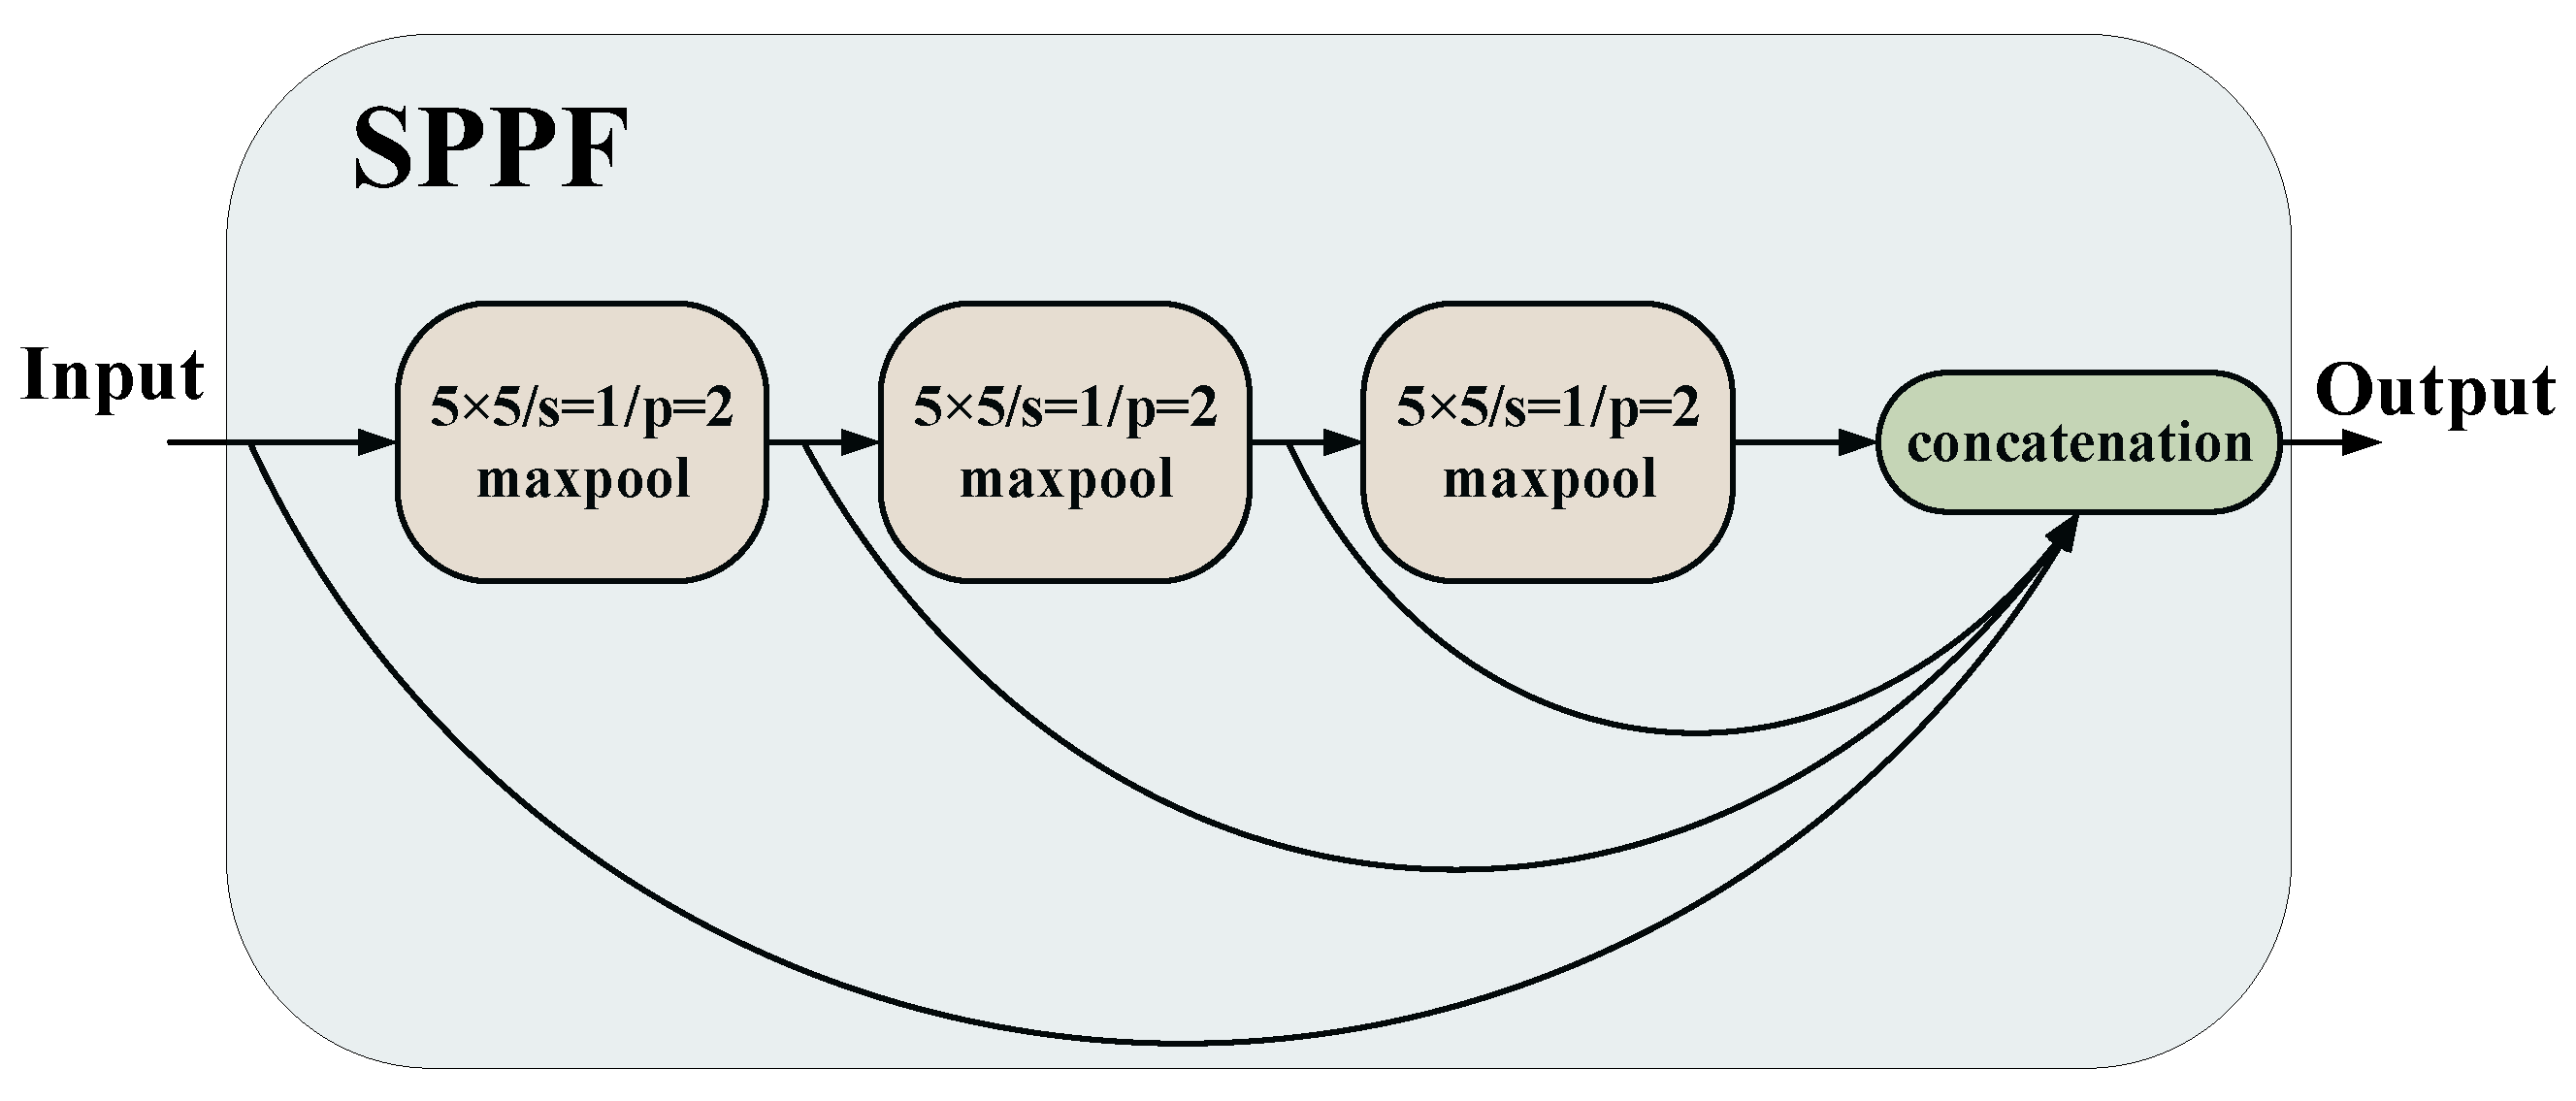

In [61]:
#-----------------SPPF - Spatial Pyramid Pooling------------------# <Neck>

class SPPF(nn.Module):
    def __init__(self, c1, c2, e=0.5, ps=5, act='lrelu', norm='bn'):
        super().__init__()
        c_ = int(c2 * e)
        c4 = c_ * 4
        self.cv1 = Conv(c1, c_, k=1, act=act, norm=norm)
        self.cv2 = Conv(c4, c2, k=1, act=act, norm=norm)
        self.pool = nn.MaxPool2d(kernel_size=ps, stride=1, padding=ps//2)

    def forward(self, x):
        y0 = self.cv1(x)
        y1 = self.pool(y0)
        y2 = self.pool(y1)
        y3 = self.pool(y2)
        out = torch.cat((y0, y1, y2, y3), dim=1)
        return self.cv2(out)

In [62]:
#-----------------YOLOv2------------------# <>

class YOLOv2(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.backbone = DarkNet19()
        self.neck = SPPF(
            c1=1024,
            c2=512,
            e=0.5,
            ps=5,
            act='lrelu',
            norm='bn'
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(
            in_features=25008, 
            out_features=n_classes
            )
    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [63]:
net = YOLOv2(n_classes=2).to('cpu')
net

YOLOv2(
  (backbone): DarkNet19(
    (layers): Sequential(
      (0): Conv_BN_LeakyReLU(
        (convs): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv_BN_LeakyReLU(
        (convs): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv_BN_LeakyReLU(
        (convs): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

### YOLOv3

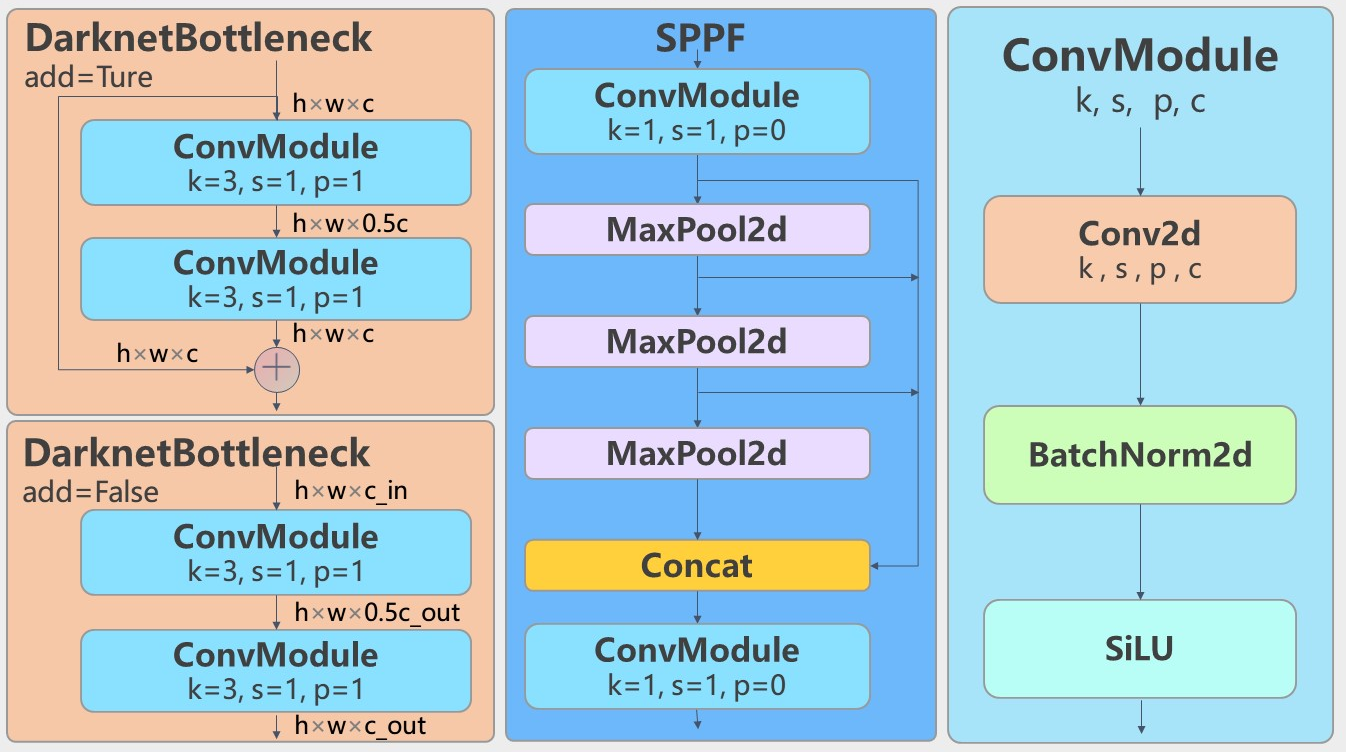

In [64]:
#-----------------Bottleneck------------------# <Neck>

class Bottleneck(nn.Module):
    def __init__(self, c1, c2, e=0.5, shortcut=False, depthwise=False, act='silu', norm='bn'):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, k=1, norm=norm, act=act)
        self.cv2 = Conv(c_, c2, k=3, p=1, norm=norm, act=act, depthwise=depthwise)
        self.shortcut = shortcut and c1 == c2

    def forward(self, x):
        h = self.cv1(x)
        h = self.cv2(h)
        return x + h if self.shortcut else h

In [65]:
#-----------------ResBlock------------------# <Block>

class ResBlock(nn.Module):
    def __init__(self, c1, c2, n=1, act='silu', norm='bn'):
        super().__init__()
        assert c1 == c2
        self.layers = nn.Sequential(*[
            Bottleneck(c1, c2, e=0.5, shortcut=True, norm=norm, act=act) for _ in range(n)
        ])
    def forward(self, x):
        return self.layers(x)

In [66]:
#-----------------Conv_BN_SiLU------------------# <Block>

class Conv_BN_SiLU(nn.Module):
    def __init__(self, c1, c2, k, p=0, s=1, d=1):
        super().__init__()
        self.layers = Conv(c1, c2, k, p, s, d, act='silu', norm='bn')
    def forward(self, x):
        return self.layers(x)

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-24_at_12.53.56_PM_QQoF5AO.png)

In [67]:
#-----------------DarkNet53------------------# <Backbone>

class DarkNet53(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            #
            Conv_BN_SiLU(3, 32, k=3, p=1),
            Conv_BN_SiLU(32, 64, k=3, p=1, s=2),
            ResBlock(64, 64, n=1, act='silu', norm='bn'),
            #
            Conv_BN_SiLU(64, 128, k=3, p=1, s=2),
            ResBlock(128, 128, n=2, act='silu', norm='bn'),
            #
            Conv_BN_SiLU(128, 256, k=3, p=1, s=2),
            ResBlock(256, 256, n=8, act='silu', norm='bn'),
            #
            Conv_BN_SiLU(256, 512, k=3, p=1, s=2),
            ResBlock(512, 512, n=8, act='silu', norm='bn'),
            #
            Conv_BN_SiLU(512, 1024, k=3, p=1, s=2),
            ResBlock(1024, 1024, n=4, act='silu', norm='bn'),
        )

    def forward(self, x):
        return self.layers(x)

In [68]:
#-----------------YOLOv3------------------# <>

class YOLOv3(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.backbone = DarkNet53()
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(
            in_features=50176,
            out_features=n_classes
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [69]:
net = YOLOv3(n_classes=2).to('cpu')
net

YOLOv3(
  (backbone): DarkNet53(
    (layers): Sequential(
      (0): Conv_BN_SiLU(
        (layers): Conv(
          (convs): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
      )
      (1): Conv_BN_SiLU(
        (layers): Conv(
          (convs): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
      )
      (2): ResBlock(
        (layers): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (convs): Sequential(
                (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(32, eps=1e-0

### YOLOv4

![image](https://www.researchgate.net/publication/358706263/figure/fig2/AS:11431281097411853@1668554449485/The-structure-of-the-residual-layer-in-Darknet53-CSPDarknet53-and-our-model.png)

In [70]:
#-----------------CSPDarkNet53------------------# <CSP-Block>

class CSPDarkNet53(nn.Module):
    def __init__(self, c1, c2, e, n, shortcut=False, depthwise=False, act='silu', norm='bn'):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, k=1, norm=norm, act=act)
        self.cv2 = Conv(c1, c_, k=1, norm=norm, act=act)
        self.cv3 = Conv(c_ * 2, c2, k=1, norm=norm, act=act)
        self.darkness53 = nn.Sequential(*[
            Bottleneck(c1, c1, e=1.0, shortcut=shortcut, norm=norm, act=act, depthwise=depthwise) for _ in range(n)
        ])

    def forward(self, x):
        x1 = self.cv1(x)
        x2 = self.cv2(x)
        x3 = self.darkness53(x2)
        out = torch.cat([x1, x3], dim=1)
        return self.cv3(out)

YOLO-v4 backbone chính là Darknet53 với sự thay thế ResBlock bằng CSPBlock (cụ thể là CSPDarknet53), chúng tôi gọi là Darknet53CSPBlock

In [71]:
#-----------------DarkNet53 with CSPBlock------------------# <Backbone>

class DarkNet53CSPBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # P1
            Conv_BN_SiLU(3, 32, k=3, p=1),
            Conv_BN_SiLU(32, 64, k=3, p=1, s=2),
            CSPDarkNet53(64, 64, e=0.5, n=1, shortcut=True, act='silu', norm='bn'),
            # P2
            Conv_BN_SiLU(64, 128, k=3, p=1, s=2),
            CSPDarkNet53(128, 128, e=0.5, n=1, shortcut=True, act='silu', norm='bn'),
            # P3
            Conv_BN_SiLU(128, 256, k=3, p=1, s=2),
            CSPDarkNet53(256, 256, e=0.5, n=1, shortcut=True, act='silu', norm='bn'),
            # P4
            Conv_BN_SiLU(256, 512, k=3, p=1, s=2),
            CSPDarkNet53(512, 512, e=0.5, n=1, shortcut=True, act='silu', norm='bn'),
            # P5
            Conv_BN_SiLU(512, 1024, k=3, p=1, s=2),
            CSPDarkNet53(1024, 1024, e=0.5, n=1, shortcut=True, act='silu', norm='bn'),
        )

    def forward(self, x):
        return self.layers(x)

In [72]:
#-----------------YOLOv4------------------# <>

class YOLOv4(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.backbone = DarkNet53CSPBlock()
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(
            in_features=50176,
            out_features=n_classes
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [73]:
net = YOLOv4(n_classes=2).to('cpu')
net

YOLOv4(
  (backbone): DarkNet53CSPBlock(
    (layers): Sequential(
      (0): Conv_BN_SiLU(
        (layers): Conv(
          (convs): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
      )
      (1): Conv_BN_SiLU(
        (layers): Conv(
          (convs): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
      )
      (2): CSPDarkNet53(
        (cv1): Conv(
          (convs): Sequential(
            (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     